In [21]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load the datasets
merged_df_adjusted = pd.read_csv('merged_df_adjusted.csv')
admissions_df = pd.read_csv('admissions.csv')

# Step 2: Merge the datasets on 'subject_id' and 'hadm_id'
merged_data = pd.merge(merged_df_adjusted, admissions_df, on=['subject_id', 'hadm_id'], how='inner')

# Drop rows with missing values in 'discharge_location' and drop 'stay_id' column
merged_data_cleaned = merged_data.dropna(subset=['discharge_location'])
merged_data_cleaned = merged_data_cleaned.drop(columns=['stay_id'])

# Step 3: Preprocess the data
# Separate features and target
# Drop unnecessary columns (including 'subject_id' and 'hadm_id') before separating features and target
X = merged_data_cleaned.drop(columns=['discharge_location', 'subject_id', 'hadm_id'])  # Features
y = merged_data_cleaned['discharge_location']  # Target

# Identify categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Encode categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Encode target variable
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

# Identify numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Normalize numerical features
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Step 4: Split data into training (70%), validation (20%), and testing sets (10%)
# First, split into 70% training and 30% temporary (which will be split into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=34)

# Then split the temporary set (30%) into validation (20%) and test (10%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=34)

# Display the sizes of each split to verify
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Step 5: Create and train the Multi-Layer Perceptron model using training data
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, activation='relu', solver='adam', random_state=34)
mlp.fit(X_train, y_train)

# Step 6: Make predictions on the validation and test sets
y_val_pred = mlp.predict(X_val)
y_test_pred = mlp.predict(X_test)

# Step 7: Evaluate the model on validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred, labels=range(len(target_encoder.classes_)), target_names=target_encoder.classes_, zero_division=0))

# Evaluate the model on the test set
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred, labels=range(len(target_encoder.classes_)), target_names=target_encoder.classes_, zero_division=0))


C:\Users\julev\AppData\Local\Temp\ipykernel_28076\1299350161.py:13: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  merged_data = pd.merge(merged_df_adjusted, admissions_df, on=['subject_id', 'hadm_id'], how='inner')


Training set size: 2865 samples
Validation set size: 819 samples
Testing set size: 410 samples
Validation Accuracy: 0.5628815628815629

Validation Classification Report:
                               precision    recall  f1-score   support

              ACUTE HOSPITAL       0.00      0.00      0.00         3
              AGAINST ADVICE       0.00      0.00      0.00         6
             ASSISTED LIVING       0.00      0.00      0.00         0
CHRONIC/LONG TERM ACUTE CARE       0.22      0.07      0.10        30
                        DIED       0.45      0.61      0.52        41
         HEALTHCARE FACILITY       0.00      0.00      0.00         1
                        HOME       0.62      0.96      0.75       430
            HOME HEALTH CARE       0.30      0.08      0.13       187
                     HOSPICE       0.00      0.00      0.00        10
              OTHER FACILITY       0.00      0.00      0.00        11
              PSYCH FACILITY       0.00      0.00      0.0

In [22]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],  # Fewer combinations for hidden layers
    'activation': ['relu'],  # Stick to 'relu' if it's already performing well
    'solver': ['adam'],  # Use 'adam' if it's typically better for your data
    'alpha': [0.0001, 0.001],  # Try fewer regularization values
    'learning_rate': ['constant', 'adaptive'],  # Keep it to two options
    'max_iter': [300]  # Fix the iteration count if you are okay with 300
}

# Initialize the MLPClassifier
mlp = MLPClassifier(random_state=34)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=8, verbose=2, scoring='accuracy')

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Display the best parameters and the corresponding accuracy
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# Use the best model found to make predictions on the test set
best_mlp = grid_search.best_estimator_
y_test_pred = best_mlp.predict(X_test)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters found:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 300, 'solver': 'adam'}
Best cross-validation accuracy: 0.57


In [23]:
# Fitting 3 folds for each of 12 candidates, totalling 36 fits
# Best parameters found:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 300, 'solver': 'adam'}
# Best cross-validation accuracy: 0.57

# Get the labels for all possible classes from the training data
all_labels = range(len(target_encoder.classes_))

# Evaluate the tuned model on the test set
print("Test Accuracy after tuning:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report after tuning:\n", 
      classification_report(y_test, y_test_pred, labels=all_labels, target_names=target_encoder.classes_, zero_division=0))


Test Accuracy after tuning: 0.5560975609756098

Test Classification Report after tuning:
                               precision    recall  f1-score   support

              ACUTE HOSPITAL       0.00      0.00      0.00         1
              AGAINST ADVICE       0.00      0.00      0.00         3
             ASSISTED LIVING       0.00      0.00      0.00         0
CHRONIC/LONG TERM ACUTE CARE       0.22      0.25      0.24         8
                        DIED       0.38      0.42      0.40        12
         HEALTHCARE FACILITY       0.00      0.00      0.00         0
                        HOME       0.65      0.87      0.75       205
            HOME HEALTH CARE       0.38      0.36      0.37       115
                     HOSPICE       0.00      0.00      0.00         4
              OTHER FACILITY       0.00      0.00      0.00         3
              PSYCH FACILITY       0.00      0.00      0.00         4
                       REHAB       0.00      0.00      0.00        15

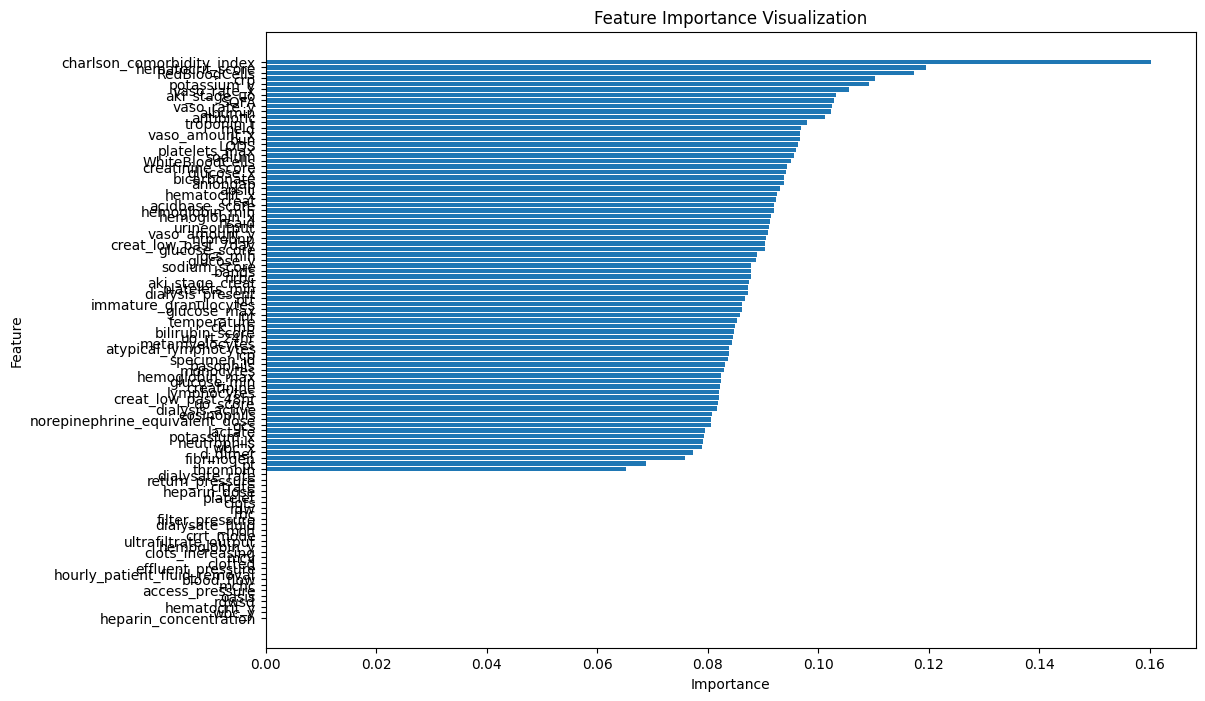

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Get the feature importances from the trained MLP model
# For MLPClassifier, we can approximate feature importance by looking at the absolute values of the weights in the first layer
feature_importance = np.mean(np.abs(best_mlp.coefs_[0]), axis=1)

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Visualization')
plt.gca().invert_yaxis()
plt.show()
